### In this assignment, we use photos from Large-scale CelebFaces Attributes (CelebA) Dataset to train convets that can classify photos into male celebrities and female celebrities accurately.

###To make this problem more challenging, we only use 2,000 photos for training, 1,000 photos for validation, and 1,000 photos for testing.

###For the first part of the assignment, following the example of chapter 5.2. Here we train our model using only the 2,000 training photos. Note we need to use data augmentation and dropout to fight overfiting. This part is worth 40 points.

###For the second part, we use a pretrained convet (VGG16) to help with our task. Do the fast feature extraction without augmentation. And do the fine-tuning following chapter 5.3.2. This part is worth 60 points.

###Important information before you start: all the photos are of the size (218, 178), where height = 218, and width = 178.

###Finally, we should be able to achieve around 94% of accuracy following the code provided by this module. Not much changes are needed.

Before we start, we need to copy hw6.zip to Google drive. And then we need to mount the Google drive using the following statements.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We then unzip hw6.zip.

In [ ]:
!unzip /content/drive/My\ Drive/hw6.zip

Archive:  /content/drive/My Drive/hw6.zip
replace hw6/test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import keras
keras.__version__

'2.14.0'

In [ ]:
import os, shutil, pathlib

In [ ]:
base_dir = '/content//hw6'
new_base_dir = pathlib.Path("hw6")

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training male pictures
train_male_dir = os.path.join(train_dir, 'male')

# Directory with our training female pictures
train_female_dir = os.path.join(train_dir, 'female')

# Directory with our validation male pictures
validation_male_dir = os.path.join(validation_dir, 'male')

# Directory with our validation female pictures
validation_female_dir = os.path.join(validation_dir, 'female')

# Directory with our validation male pictures
test_male_dir = os.path.join(test_dir, 'male')

# Directory with our validation female pictures
test_female_dir = os.path.join(test_dir, 'female')

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [ ]:
print('total training male images:', len(os.listdir(train_male_dir)))

total training male images: 825


In [ ]:
print('total training female images:', len(os.listdir(train_female_dir)))

total training female images: 1175


In [ ]:
print('total validation male images:', len(os.listdir(validation_male_dir)))

total validation male images: 413


In [ ]:
print('total validation female images:', len(os.listdir(validation_female_dir)))

total validation female images: 587


In [ ]:
print('total test male images:', len(os.listdir(test_male_dir)))

total test male images: 412


In [ ]:
print('total test female images:', len(os.listdir(test_female_dir)))

total test female images: 588


Using DataGenerators for Data Augmentation & to gather images

In [ ]:
from keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(218, 178),
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(218, 178),
 batch_size=32)
test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(218, 178),
 batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
from keras import layers
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

Some (possibly) funny randomly augmented training images. At one point I got a guy looking really silly in a christmas hat but I reset the runtime so sadly its gone... :(  
  (I had happened to be listening to Christmas music when I saw that)

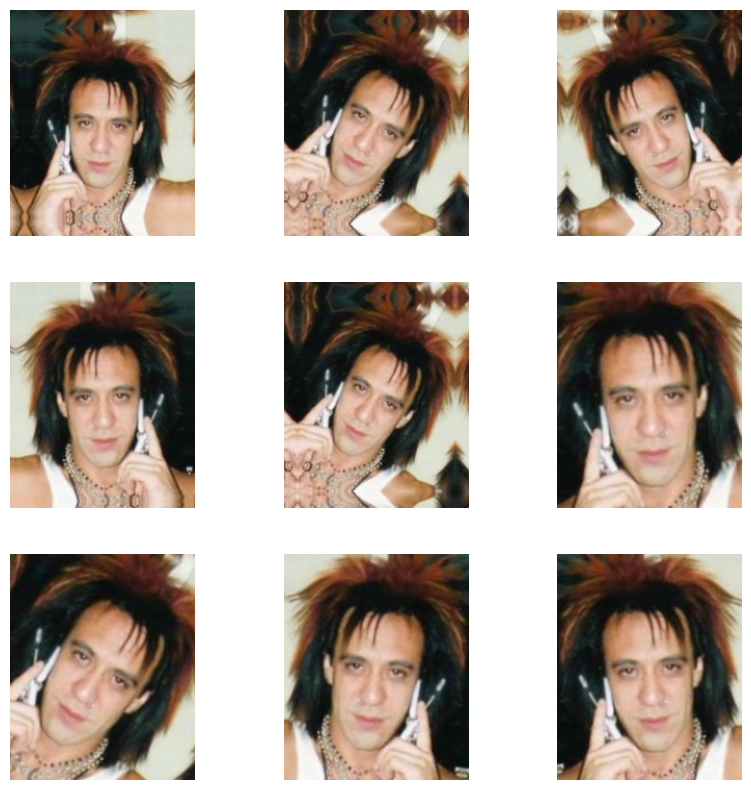

In [ ]:
import matplotlib.pyplot as plt
import numpy
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Defined Convnet with image augmentation and dropout

In [ ]:
inputs = keras.Input(shape=(218, 178, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="gender_convnet.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 5s 54ms/step - loss: 0.6850 - accuracy: 0.5780 - val_loss: 0.6694 - val_accuracy: 0.5870
Epoch 2/100
63/63 [==============================] - 3s 51ms/step - loss: 0.6506 - accuracy: 0.6260 - val_loss: 0.5768 - val_accuracy: 0.7270
Epoch 3/100
63/63 [==============================] - 3s 51ms/step - loss: 0.6059 - accuracy: 0.6745 - val_loss: 0.5338 - val_accuracy: 0.7370
Epoch 4/100
63/63 [==============================] - 3s 51ms/step - loss: 0.5670 - accuracy: 0.7060 - val_loss: 0.5222 - val_accuracy: 0.7530
Epoch 5/100
63/63 [==============================] - 3s 51ms/step - loss: 0.5237 - accuracy: 0.7555 - val_loss: 0.4120 - val_accuracy: 0.7910
Epoch 6/100
63/63 [==============================] - 3s 51ms/step - loss: 0.4623 - accuracy: 0.7850 - val_loss: 0.4264 - val_accuracy: 0.8130
Epoch 7/100
63/63 [==============================] - 3s 52ms/step - loss: 0.4437 - accuracy: 0.7965 - val_loss: 0.3593 - val_accuracy: 0.8490
Epoch 

Instantiate the VGG16 convolutional base for use with fast feature extraction

In [ ]:
conv_base = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(218, 178, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

Extract features and labels from VGG16

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


Freeze up to last 4 layers of the conv base then chain it with data augmentation + the base classifier

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False
inputs = keras.Input(shape=(218, 178, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="fine_tuning.h5",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 195ms/step - loss: 2.4183 - accuracy: 0.6785 - val_loss: 0.5980 - val_accuracy: 0.8760
Epoch 2/30
63/63 [==============================] - 12s 193ms/step - loss: 0.8655 - accuracy: 0.8180 - val_loss: 0.4926 - val_accuracy: 0.8880
Epoch 3/30
63/63 [==============================] - 12s 193ms/step - loss: 0.5481 - accuracy: 0.8485 - val_loss: 0.3263 - val_accuracy: 0.9150
Epoch 4/30
63/63 [==============================] - 12s 193ms/step - loss: 0.3790 - accuracy: 0.8845 - val_loss: 0.3054 - val_accuracy: 0.9110
Epoch 5/30
63/63 [==============================] - 12s 192ms/step - loss: 0.3172 - accuracy: 0.8930 - val_loss: 0.2288 - val_accuracy: 0.9250
Epoch 6/30
63/63 [==============================] - 12s 192ms/step - loss: 0.2238 - accuracy: 0.9215 - val_loss: 0.1707 - val_accuracy: 0.9360
Epoch 7/30
63/63 [==============================] - 12s 187ms/step - loss: 0.2033 - accuracy: 0.9275 - val_loss: 0.1992 - val_accuracy: 0.9380

Finish the rest by modifying the code provided in this module. Note not much changes expected. Below is the test accuracy obtained from one of the runs.

In [ ]:
model = keras.models.load_model("fine_tuning.h5")
test_loss, test_acc = model.evaluate(test_dataset, steps=20)
print('test acc:', test_acc)

20/20 [==============================] - 2s 113ms/step - loss: 0.2028 - accuracy: 0.9406
test acc: 0.940625011920929


Here we get a test accuracy of 94% with only 2,000 training samples.